In [1]:
print("meowmeow")

print("hello?")

print("hehehaha")

meowmeow
hello?
hehehaha


In [2]:
print("kaiyi test")

print("weeeeeee")
print("weyuwuye")

kaiyi test
weeeeeee
weyuwuye


In [3]:
import cv2 # Will be used for edge detection further on
import os 
import numpy as np  # For numerical operations
from PIL import Image, ImageEnhance  # For image loading and augmentation
import matplotlib.pyplot as plt  # For visualization
from sklearn.preprocessing import LabelEncoder  # For encoding labels
import random  # For random transformations


In [4]:
from PIL import Image, ImageEnhance, ImageFilter


# Set Parameters
target_size = (224, 224)  # Standard input size for CNN
rotation_prob = 0.4  # 40% chance of rotation
saturation_prob = 0.5  # 50% chance of saturation change
min_saturation = 0.7  # Min saturation level
max_saturation = 1.3  # Max saturation level
blur_prob = 0.5  # 50% chance of blur
noise_prob = 0.5  # 50% chance of noise
min_crop_size = (70, 70)  # Minimum size of crop to avoid cutting off too much
padding = 80  # Padding to avoid cutting off important parts of the image
border_threshold = 5 # For the black border threshold count

# To crop out the edges
def auto_crop(img, padding=5, min_crop_size=(70, 70)):
    """
    Crops the image to the largest contour found using Canny edge detection.
    Returns the original image if no valid contour is found.
    """
    if isinstance(img, Image.Image):
        img_cv = np.array(img)
    else:
        img_cv = img.copy()

    gray = cv2.cvtColor(img_cv, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, threshold1=50, threshold2=100)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [c for c in contours if cv2.contourArea(c) > 300]  # slightly more relaxed

    if contours:
        # Use the largest contour
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        x = max(0, x - padding)
        y = max(0, y - padding)
        x_end = min(img.width, x + w + 2 * padding)
        y_end = min(img.height, y + h + 2 * padding)

        cropped = img.crop((x, y, x_end, y_end))
        
        # Only return cropped if it still has valid size
        if cropped.size[0] >= min_crop_size[0] and cropped.size[1] >= min_crop_size[1]:
            return cropped

    return img  # fallback: return original image if crop fails



# Function to resize image
def resize_image(img, target_size=(224, 224)):
    return img.resize(target_size, Image.LANCZOS)


# Function to apply random blur to an image
def apply_random_blur(img, prob=0.5):
    if random.random() < prob:
        radius = random.uniform(0.1, 2.0)  # Random blur radius
        return img.filter(ImageFilter.GaussianBlur(radius))
    return img  # No blur

# Function to add random noise to an image
def add_random_noise(img, prob=0.5):
    if random.random() < prob:
        img_array = np.array(img)
        noise = np.random.normal(0, 0.1, img_array.shape)  # Add Gaussian noise
        noisy_img_array = img_array + noise * 255  # Scale noise
        noisy_img_array = np.clip(noisy_img_array, 0, 255).astype(np.uint8)  # Ensure values are valid
        return Image.fromarray(noisy_img_array)
    return img  # No noise

# Function to adjust saturation
def adjust_saturation(img, min_factor=0.7, max_factor=1.3, prob=0.5):
    if random.random() < prob:
        factor = random.uniform(min_factor, max_factor)
        enhancer = ImageEnhance.Color(img)
        return enhancer.enhance(factor)
    return img  # No change


def rotate_image(img, max_angle=10, rotation_prob=0.4):
    """Random rotation with proper border handling"""
    if random.random() < rotation_prob:
        angle = random.uniform(-max_angle, max_angle)
        
        # Rotate on expanded canvas
        rotated = img.rotate(angle, expand=True, resample=Image.BILINEAR)
        
        # Convert to numpy array for border detection
        np_img = np.array(rotated)
        
        if np_img.ndim == 3:  # Color image
            # Find non-black pixels (any channel > threshold)
            non_black = np.any(np_img > border_threshold, axis=2)
        else:  # Grayscale
            non_black = np_img > border_threshold
            
        if np.any(non_black):
            # Get bounding box coordinates
            rows = np.any(non_black, axis=1)
            cols = np.any(non_black, axis=0)
            y_min, y_max = np.where(rows)[0][[0, -1]]
            x_min, x_max = np.where(cols)[0][[0, -1]]
            
            # Crop and convert back to PIL
            cropped = rotated.crop((x_min, y_min, x_max, y_max))
            return cropped.resize(target_size, Image.LANCZOS)
    
    # Return original if no rotation or if border removal failed
    return img.resize(target_size, Image.LANCZOS) if rotation_prob else img

# Function to adjust brightness
def adjust_brightness(img, min_factor=1.1, max_factor=1.5, prob=0.5):
    if random.random() < prob:
        factor = random.uniform(min_factor, max_factor)
        enhancer = ImageEnhance.Brightness(img)
        return enhancer.enhance(factor)
    return img  # No change





In [ ]:
################### I(ame) replaced this chunk of code with the code below to experiment (dont run this) #############################

train_folder = "Train"  # Change to your dataset path
train_images = []
train_labels = []

for img_file in os.listdir(train_folder):
    if img_file.endswith(".png"):
        img_path = os.path.join(train_folder, img_file)

        # Load image using PIL
        img = Image.open(img_path).convert("RGB")

        # Extract class label from filename
        class_label = int(img_file.split("__")[0])

        # Apply preprocessing
        img = rotate_image(img, max_angle=10, rotation_prob=rotation_prob)  # Selective Rotation
        img = auto_crop(img)  # Crop after rotation
        img = adjust_brightness(img, prob=0.5) # adjust the brightness of images if they are darkened
        img = adjust_saturation(img, min_factor=min_saturation, max_factor=max_saturation, prob=saturation_prob)  # Selective Saturation
        img = apply_random_blur(img, prob=blur_prob)  # Random image blurring
        img = add_random_noise(img, prob=noise_prob)  # Apply random noise to some images
        img = resize_image(img, target_size)  # Resize after all transformations
        
        
        # Convert image to NumPy array and normalize
        img = np.array(img) / 255.0  

        # Store processed image and label
        train_images.append(img)
        train_labels.append(class_label)

# Convert to NumPy arrays
X_train = np.array(train_images)
y_train = np.array(train_labels)
 
 


In [5]:
from collections import Counter

train_folder = "Train"
train_images = []
train_labels = []

# Define what we consider a "rare class"
rare_threshold = 150 
extra_copies = 2       # generated 3 extra augmented data for rare classes

# First, count how many samples each class has
all_labels = [int(f.split("__")[0]) for f in os.listdir(train_folder) if f.endswith(".png")]
class_counts = Counter(all_labels)
rare_classes = [cls for cls, count in class_counts.items() if count < rare_threshold]

print(f"Rare classes: {rare_classes}")

for img_file in os.listdir(train_folder):
    if not img_file.endswith(".png"):
        continue

    img_path = os.path.join(train_folder, img_file)
    class_label = int(img_file.split("__")[0])
    img = Image.open(img_path).convert("RGB")
    img = auto_crop(img)

    def process_and_store(img_obj):
        img_aug = img_obj.copy()

        # Apply augmentations
        if class_label in rare_classes:
            # Strong augmentations for rare classes
            img_aug = adjust_brightness(img_aug, prob=1.0)
            img_aug = adjust_saturation(img_aug, min_factor=0.6, max_factor=1.6, prob=1.0)
            img_aug = rotate_image(img_aug, max_angle=15, rotation_prob=1.0)
            img_aug = apply_random_blur(img_aug, prob=1.0)
            img_aug = add_random_noise(img_aug, prob=1.0)
        else:
            # Standard augmentations for non-rare
            img_aug = rotate_image(img_aug, max_angle=10, rotation_prob=rotation_prob)
            img_aug = adjust_brightness(img_aug, prob=0.5)
            img_aug = adjust_saturation(img_aug, min_factor=min_saturation, max_factor=max_saturation, prob=saturation_prob)
            img_aug = apply_random_blur(img_aug, prob=blur_prob)
            img_aug = add_random_noise(img_aug, prob=noise_prob)

        # Final steps
        img_aug = resize_image(img_aug, target_size)
        img_aug = np.array(img_aug) / 255.0
        train_images.append(img_aug)
        train_labels.append(class_label)

    # Always process the original once
    process_and_store(img)

    # Generate more copies for rare classes
    if class_label in rare_classes:
        for _ in range(extra_copies):
            process_and_store(img)

# Convert to NumPy arrays
X_train = np.array(train_images)
y_train = np.array(train_labels)


Rare classes: [11, 18, 9, 7, 23, 14, 20, 12, 1, 5, 10, 3, 13, 19]


In [24]:
from collections import Counter
from PIL import Image
import os
import numpy as np

train_folder = "Train"
train_images = []
train_labels = []

# Define rare class threshold and augmentation params
rare_threshold = 150
extra_copies = 2

# Low-quality filtering thresholds
min_file_size_kb = 10
min_resolution = (40, 40)

# First, count class frequencies
all_labels = [int(f.split("__")[0]) for f in os.listdir(train_folder) if f.endswith(".png")]
class_counts = Counter(all_labels)
rare_classes = [cls for cls, count in class_counts.items() if count < rare_threshold]

print(f"Rare classes: {rare_classes}")

# Function to detect low-quality images
def is_low_quality(file_path):
    if os.path.getsize(file_path) < min_file_size_kb * 1024:
        return True
    try:
        img = Image.open(file_path)
        return img.width < min_resolution[0] or img.height < min_resolution[1]
    except:
        return True
    return False

for img_file in os.listdir(train_folder):
    if not img_file.endswith(".png"):
        continue

    img_path = os.path.join(train_folder, img_file)

    # Skip low-quality images
    if is_low_quality(img_path):
        print(f"Skipping low-quality: {img_file}")
        continue

    class_label = int(img_file.split("__")[0])
    img = Image.open(img_path).convert("RGB")
    img = auto_crop(img)

    def process_and_store(img_obj):
        img_aug = img_obj.copy()

        # Apply augmentations
        if class_label in rare_classes:
            img_aug = adjust_brightness(img_aug, prob=1.0)
            img_aug = adjust_saturation(img_aug, min_factor=0.6, max_factor=1.6, prob=1.0)
            img_aug = rotate_image(img_aug, max_angle=15, rotation_prob=1.0)
            img_aug = apply_random_blur(img_aug, prob=1.0)
            img_aug = add_random_noise(img_aug, prob=1.0)
        else:
            img_aug = rotate_image(img_aug, max_angle=10, rotation_prob=rotation_prob)
            img_aug = adjust_brightness(img_aug, prob=0.5)
            img_aug = adjust_saturation(img_aug, min_factor=min_saturation, max_factor=max_saturation, prob=saturation_prob)
            img_aug = apply_random_blur(img_aug, prob=blur_prob)
            img_aug = add_random_noise(img_aug, prob=noise_prob)

        # Resize, normalize, and store
        img_aug = resize_image(img_aug, target_size)
        img_aug = np.array(img_aug) / 255.0
        train_images.append(img_aug)
        train_labels.append(class_label)

    # Store original image
    process_and_store(img)

    # Add more versions if rare class
    if class_label in rare_classes:
        for _ in range(extra_copies):
            process_and_store(img)

# Convert to arrays
X_train = np.array(train_images)
y_train = np.array(train_labels)


Rare classes: [11, 18, 9, 7, 23, 14, 20, 12, 1, 5, 10, 3, 13, 19]
Skipping low-quality: 21__4088.png
Skipping low-quality: 0__1102 2.png
Skipping low-quality: 21__1994 2.png
Skipping low-quality: 8__1339.png
Skipping low-quality: 2__112.png
Skipping low-quality: 7__3368.png
Skipping low-quality: 0__29 2.png
Skipping low-quality: 21__2002.png
Skipping low-quality: 4__2321.png
Skipping low-quality: 0__30 2.png
Skipping low-quality: 21__2003.png
Skipping low-quality: 0__2114 2.png
Skipping low-quality: 8__1337 2.png
Skipping low-quality: 11__3515.png
Skipping low-quality: 8__1338.png
Skipping low-quality: 7__3382.png
Skipping low-quality: 21__4089.png
Skipping low-quality: 4__2280.png
Skipping low-quality: 21__4048.png
Skipping low-quality: 22__3075.png
Skipping low-quality: 4__1206.png
Skipping low-quality: 21__2001.png
Skipping low-quality: 0__1098 2.png
Skipping low-quality: 21__1938.png
Skipping low-quality: 21__2000.png
Skipping low-quality: 10__1410.png
Skipping low-quality: 4__2280

Class 0: 161 samples
Class 1: 252 samples
Class 2: 279 samples
Class 3: 288 samples
Class 4: 191 samples
Class 5: 249 samples
Class 6: 159 samples
Class 7: 216 samples
Class 8: 106 samples
Class 9: 315 samples
Class 10: 387 samples
Class 11: 378 samples
Class 12: 411 samples
Class 13: 330 samples
Class 14: 417 samples
Class 15: 469 samples
Class 16: 169 samples
Class 17: 172 samples
Class 18: 183 samples
Class 19: 249 samples
Class 20: 180 samples
Class 21: 296 samples
Class 22: 174 samples
Class 23: 348 samples


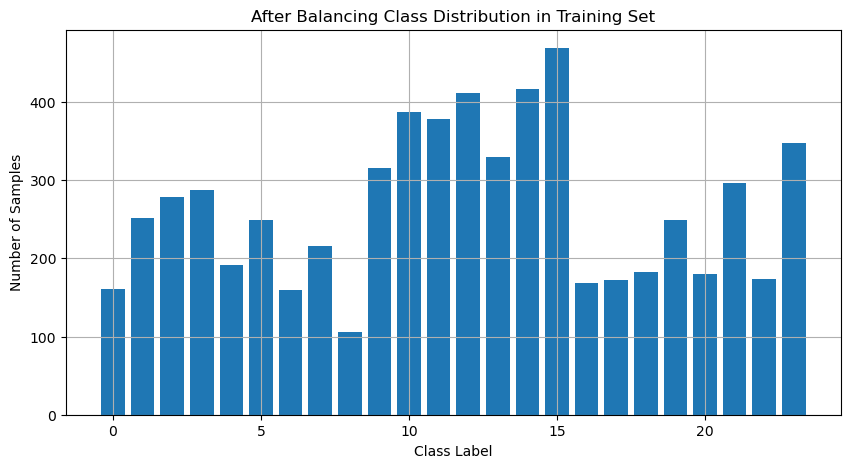

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Count samples per class
unique_classes, class_counts = np.unique(y_train, return_counts=True)

for label, count in zip(unique_classes, class_counts):
    print(f"Class {label}: {count} samples") # Print each class and respective samples

# Plotting the distribution of the classes
plt.figure(figsize=(10, 5))
plt.bar(unique_classes, class_counts)
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("After Balancing Class Distribution in Training Set")
plt.grid(True)
plt.show()


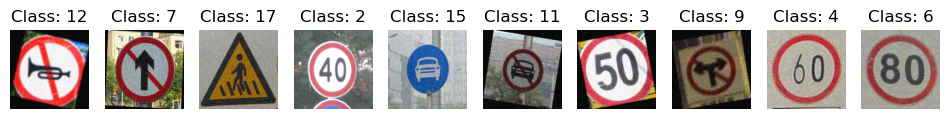

In [30]:
num_samples = 10  # Number of images to display
random_indices = random.sample(range(len(X_train)), num_samples)
#random_indices = np.size(random.sample(range(len(X_train)), 1))
#print(random_indices)
plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(X_train[idx])  # Show image
    plt.title(f"Class: {y_train[idx]}")
    plt.axis("off")

plt.show()


In [31]:
test_folder = "Test"  # Replace with actual test folder name
test_images = []
test_labels = []

for img_file in os.listdir(test_folder):
    if img_file.endswith(".png"):
        img_path = os.path.join(test_folder, img_file)
        img = Image.open(img_path).convert("RGB")

        class_label = int(img_file.split("__")[0])

        # Preprocessing: only clean, no augmentation
        img = auto_crop(img)  # Optional but keeps it consistent
        img = resize_image(img, target_size)
        img = np.array(img) / 255.0  # Normalize to [0, 1]

        test_images.append(img)
        test_labels.append(class_label)

X_test = np.array(test_images)
y_test = np.array(test_labels)

# this is my test data


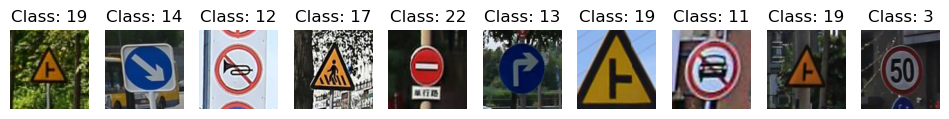

In [32]:
num_samples = 10
random_indices = random.sample(range(len(X_test)), num_samples)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"Class: {y_test[idx]}")
    plt.axis("off")

plt.show()


# CNN Modeling

## Loading Train and Test data

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import WeightedRandomSampler

import matplotlib.pyplot as plt
import numpy

batch_size = 64

# Defining device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # mps if using mac gpu, else use cpu

# Convert numpy arrays to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create datasets
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## CNN Model (Minimal layers)

In [76]:
input_size = 224*224
output_size = len(np.unique(y_train)) #number of classes=24

class CNN(nn.Module):
    def __init__(self, output_size = 24): #n_features = number of filters (feature maps)
        super(CNN, self).__init__() 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5) # input channel = 3 to allow for rgb image, update kernel size accordingly based on the input size
        self.pool = nn.MaxPool2d(2, 2) # (224 → 220 → 110)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5) # (110 → 106 → 53)

        # After conv2 + pooling, the feature map size is: [16, 53, 53]
        self.fc1 = nn.Linear(16*53*53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output_size) #adjust input and output variables accordingly

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 6, 110, 110]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 16, 53, 53]
        x = x.view(x.size(0), -1)             # flatten to [B, 16*53*53]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



## Model Variables 

In [71]:
# Variables for our model
# (TO BE ADJUSTED BASED ON HOW WE WANT TO TRAIN THE MODEL)
n_features = 32 #32 convolutional filters in first conv layer 
learning_rate = 0.0005 #reduced learning rate for more stable training
num_epochs = 20

In [72]:
# Initialising the CNN model 
model = CNN(output_size=24)
model = model.to(device)

# Use in your loss function
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer (can change) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.0001)  #used Adam optimiser instead: converges faster and better for classification tasks


## Model Training

In [73]:
# TRAINING 

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

# Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

        # Calculate accuracy by calculating loss against predicted loss
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    #store losses and accuracy in train_losses and train_accuracies
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - " f"Train Loss: {avg_train_loss:.4f} - Train Acc: {train_accuracy:.2f}%")

Epoch [1/20] - Train Loss: 2.6923 - Train Acc: 20.35%
Epoch [2/20] - Train Loss: 1.5999 - Train Acc: 50.57%
Epoch [3/20] - Train Loss: 0.9676 - Train Acc: 68.44%
Epoch [4/20] - Train Loss: 0.6802 - Train Acc: 77.13%
Epoch [5/20] - Train Loss: 0.5235 - Train Acc: 82.57%
Epoch [6/20] - Train Loss: 0.4209 - Train Acc: 85.34%
Epoch [7/20] - Train Loss: 0.3361 - Train Acc: 88.02%
Epoch [8/20] - Train Loss: 0.2631 - Train Acc: 91.24%
Epoch [9/20] - Train Loss: 0.2080 - Train Acc: 92.73%
Epoch [10/20] - Train Loss: 0.1960 - Train Acc: 93.29%
Epoch [11/20] - Train Loss: 0.1309 - Train Acc: 96.24%
Epoch [12/20] - Train Loss: 0.1292 - Train Acc: 95.80%
Epoch [13/20] - Train Loss: 0.1032 - Train Acc: 96.60%
Epoch [14/20] - Train Loss: 0.0907 - Train Acc: 97.04%
Epoch [15/20] - Train Loss: 0.0745 - Train Acc: 97.62%
Epoch [16/20] - Train Loss: 0.0761 - Train Acc: 97.52%
Epoch [17/20] - Train Loss: 0.0878 - Train Acc: 97.34%
Epoch [18/20] - Train Loss: 0.0538 - Train Acc: 98.34%
Epoch [19/20] - Tra

## Plotting Train Loss and Train Accuracy

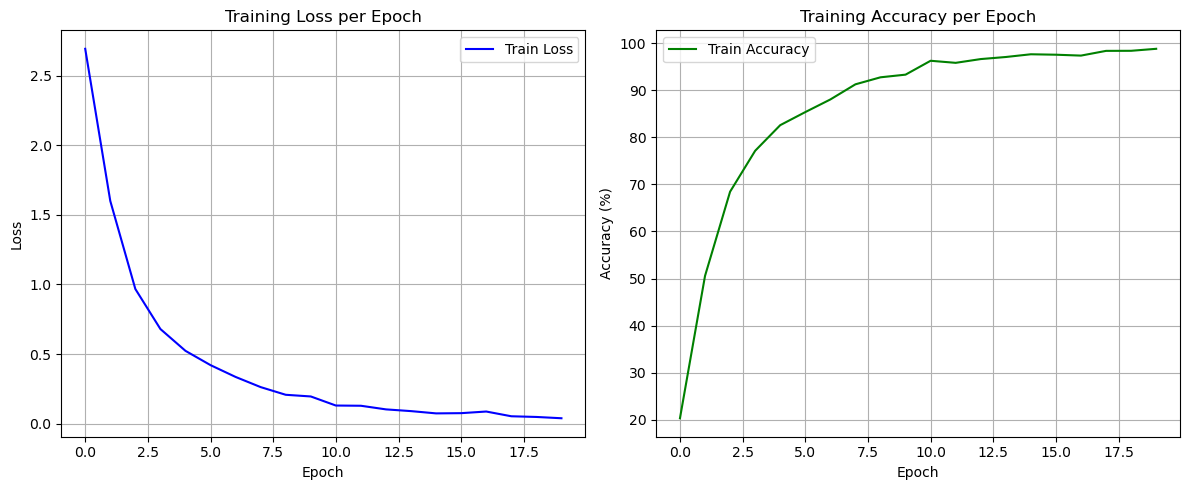

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", color="blue")
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", color="green")
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## Model Testing 

### Model Evaluation: Confusion Matrix


Test Loss: 2.5697
Test Accuracy: 65.62%


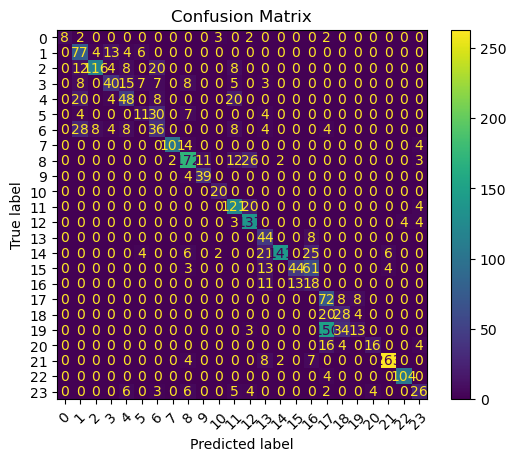

              precision    recall  f1-score   support

           0      1.000     0.471     0.640        17
           1      0.510     0.740     0.604       104
           2      0.906     0.690     0.784       168
           3      0.615     0.430     0.506        93
           4      0.539     0.480     0.508       100
           5      0.393     0.196     0.262        56
           6      0.346     0.360     0.353       100
           7      0.981     0.927     0.953       109
           8      0.804     0.754     0.778       228
           9      0.780     0.907     0.839        43
          10      0.800     1.000     0.889        20
          11      0.665     0.834     0.740       145
          12      0.714     0.926     0.806       148
          13      0.407     0.846     0.550        52
          14      0.972     0.688     0.806       205
          15      0.772     0.352     0.484       125
          16      0.151     0.429     0.224        42
          17      0.267    

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_true = []
y_pred = []

model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Final metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f"\nTest Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, digits=3))
